# Лабораторная работа 4. Дисперсионный анализ
## Титульная информация

Нимеева Ангелина Борисовна, ИСУ 466898, группа J3111

Шумбалов Айдар Мухамбеткалиевич, ИСУ 489607, группа J3114

Степанов Виктор Михайлович, ИСУ 467592, группа J3113

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import  t, f
from itertools import combinations

# Ход работы

Нормальное распределение задаётся по формуле
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$
где $\mu$ - математическое ожидание, $\sigma$ - стандартное отклонение.

# Генерация и визуализация данных
Сгенерируйте две выборки из нормального распределения, каждая из которых аккумулирует три подвыборки (группы)
* Группы имеют одинаковые дисперсию и близкие (сильно меньше стандартного отклонения) математические ожидания.
* Группы имеют одинаковые дисперсии и заметно отличающиеся математические ожидания.

In [2]:
np.random.seed(42)
N = 500

In [3]:
# выборка 1: группы с одинаковыми дисперсиями и близкими математическими ожиданиями
group1_1 = np.random.normal(loc=5, scale=1, size=N//3)
group1_2 = np.random.normal(loc=5.5, scale=1, size=N//3)
group1_3 = np.random.normal(loc=5.2, scale=1, size=N//3)

# выборка 2: группы с одинаковыми дисперсиями и заметно отличающимися математическими ожиданиями
group2_1 = np.random.normal(loc=2, scale=1, size=N//3)
group2_2 = np.random.normal(loc=7, scale=1, size=N//3)
group2_3 = np.random.normal(loc=12, scale=1, size=N//3)

# объединение групп
group1 = np.concatenate([group1_1, group1_2, group1_3])
group2 = np.concatenate([group2_1, group2_2, group2_3])


KDE - ядерная оценка плотности (Kernel density estimate)

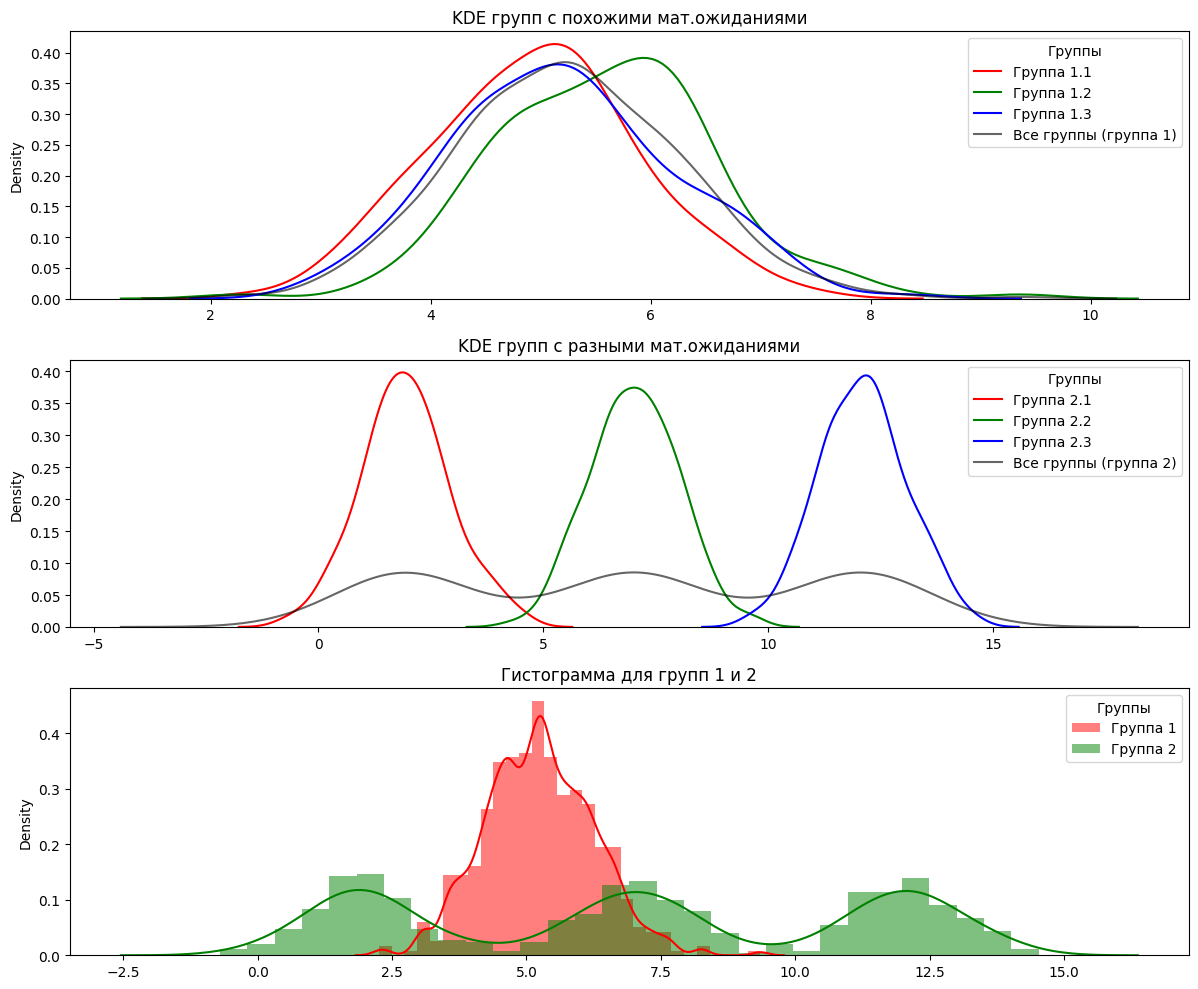

In [4]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
sns.kdeplot(group1_1, label='Группа 1.1', color='r')
sns.kdeplot(group1_2, label='Группа 1.2', color='g')
sns.kdeplot(group1_3, label='Группа 1.3', color='b')
sns.kdeplot(group1, label='Все группы (группа 1)', color='black', alpha=0.6)
plt.title('KDE групп с похожими мат.ожиданиями')
plt.legend(title='Группы', loc='upper right')

plt.subplot(3, 1, 2)
sns.kdeplot(group2_1, label='Группа 2.1', color='r')
sns.kdeplot(group2_2, label='Группа 2.2', color='g')
sns.kdeplot(group2_3, label='Группа 2.3', color='b')
sns.kdeplot(group2, label='Все группы (группа 2)', color='black', alpha=0.6)
plt.title('KDE групп с разными мат.ожиданиями')
plt.legend(title='Группы', loc='upper right')

plt.subplot(3, 1, 3)
plt.hist(group1, bins=30, density=True, alpha=0.5, color='r', label='Группа 1')
plt.hist(group2, bins=30, density=True, alpha=0.5, color='g', label='Группа 2')
sns.kdeplot(group1, bw_adjust=0.5, color='r')
sns.kdeplot(group2, bw_adjust=0.5, color='g')
plt.title('Гистограмма для групп 1 и 2')
plt.legend(title='Группы', loc='upper right')

plt.tight_layout()
plt.show()

# Парные тесты
1. Реализуйте парный тест для проверки гипотезы о равенстве математических ожиданий
при известных дисперсиях.
2. Реализуйте парный тест для проверки гипотезы о равенстве математических ожиданий
при неизвестных, но равных дисперсиях.
3. Примените оба вида тестов для всех пар групп для каждой из выборок.

Парный тест для известных дисперсий (z-тест):
$$
z = \frac{\overline{X}_1 - \overline{X}_2}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}
$$
где $\overline{X}_1, \overline{X}_2$ - это разница между средними значениями двух выборок. Это то, что мы пытаемся проверить: является ли эта разница статистически значимой или случайной.

Проводим тест с двухсторонней гипотезой: ${𝐻}_0: {𝜇}_1 = {𝜇}_2$ против альтернативной гипотезы ${H}_0​: {μ}_1 ≠ {μ}_2$

In [5]:
def z_test(group1, group2, sigma=1.0, alpha=0.05):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    se = np.sqrt((sigma ** 2) / n1 + (sigma ** 2) / n2)
    z_stat = (mean1 - mean2) / se
    # двустороннее p-значение
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    reject_null = p_value < alpha
    return z_stat, p_value, reject_null

Парный тест для неизвестных, но равных дисперсий (t-тест):
$$
z = \frac{\overline{X}_1 - \overline{X}_2}{{S}_p\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}
$$
где ${S}_p$ - объединённая оценка стандартного отклонения:
$$
S_p = \sqrt{\frac{(n_1 - 1)S_1^2 + (n_2 - 1)S_2^2}{n_1 + n_2 - 2}}
$$
где ${S_1^2}, {S_2^2}$ - выборочные дисперсии для групп

In [6]:
def t_test(group1, group2, alpha=0.05):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    se = np.sqrt(pooled_var * (1/n1 + 1/n2))

    t_stat = (mean1 - mean2) / se
    df = n1 + n2 - 2
    # двустороннее p-значение
    p_value = 2 * (1 - t.cdf(abs(t_stat), df))
    reject_null = p_value < alpha
    return t_stat, p_value, reject_null

In [7]:
def pair_tests(groups, alpha=0.05):
    print(f"{'Пара':<10} {'Z':>10} {'p':>10} {'Z (denied)':>12} {'T':>10} {'p':>10} {'T (denied)':>12}")
    for i, j in combinations(range(len(groups)), 2):
        # Выполняем z-тест
        z_stat, pz, rz = z_test(groups[i], groups[j])
        # Выполняем t-тест
        t_stat, pt, rt = t_test(groups[i], groups[j])
        # Выводим результаты
        print(f"{i+1}-{j+1:<8} {z_stat:10.3f} {pz:10.3f} {str(rz):>12} {t_stat:10.3f} {pt:10.3f} {str(rt):>12}")

groups1 = [group1_1, group1_2, group1_3]
groups2 = [group2_1, group2_2, group2_3]

print("Выборка 1")
pair_tests(groups1)

print("Выборка 2")
pair_tests(groups2)

Выборка 1
Пара                Z          p   Z (denied)          T          p   T (denied)
1-2            -5.898      0.000         True     -6.100      0.000         True
1-3            -2.321      0.020         True     -2.387      0.018         True
2-3             3.577      0.000         True      3.569      0.000         True
Выборка 2
Пара                Z          p   Z (denied)          T          p   T (denied)
1-2           -46.303      0.000         True    -47.049      0.000         True
1-3           -92.550      0.000         True    -94.412      0.000         True
2-3           -46.246      0.000         True    -47.644      0.000         True


# ANOVA (oднофакторный дисперсионный анализ)
Используя однофакторный дисперсионный анализ и F-тест, проверьте гипотезу о равенстве
всех средних групп в рамках выборок.

Процесс выполнения ANOVA:

1. Для каждой группы мы вычисляем среднее значение и дисперсию.

2. Рассчитываем межгрупповую дисперсию (отличия средних значений между группами) и внутригрупповую дисперсию (разброс внутри каждой группы).

3. Вычисляем статистику F с помощью отношения межгрупповой дисперсии к внутригрупповой:
$$
F = \frac{Межгрупповая\quadдисперсия}{Внутригрупповая\quadдисперсия}
$$

In [8]:
def anova(groups, alpha=0.05):
    k = len(groups)
    n_total = sum(len(g) for g in groups)
    grand_mean = np.mean(np.concatenate(groups))

    # Межгрупповая сумма квадратов (SSB)
    ssb = sum(len(g) * (np.mean(g) - grand_mean) ** 2 for g in groups)
    msb = ssb / (k - 1)

    # Внутригрупповая сумма квадратов (SSW)
    ssw = sum(np.sum((g - np.mean(g)) ** 2) for g in groups)
    msw = ssw / (n_total - k)

    F_stat = msb / msw
    p_value = 1 - f.cdf(F_stat, dfn=k-1, dfd=n_total - k)
    reject = p_value < alpha
    return F_stat, p_value, reject

In [9]:
print("Группа 1 (схожие средние значения)")
f_stat_1, p_val_1, reject_h0_1 = anova(groups1)
print(f"F-статистика = {f_stat_1:.3f}, p = {p_val_1:.3f}, отклоняем H0: {reject_h0_1}")

print("Группа 2 (различные средние значения)")
f_stat_2, p_val_2, reject_h0_2 = anova(groups2)
print(f"F-статистика = {f_stat_2:.3f}, p = {p_val_2:.3f}, отклоняем H0: {reject_h0_2}")

Группа 1 (схожие средние значения)
F-статистика = 18.363, p = 0.000, отклоняем H0: True
Группа 2 (различные средние значения)
F-статистика = 4474.103, p = 0.000, отклоняем H0: True


# Выводы
Анализ данных с использованием ANOVA и парных тестов показал значительные различия между группами. Результаты подтвердили эффективность алгоритмов анализа данных и их применимость для данных.